In [ ]:
%matplotlib inline 

import nltk
import torch 
import sklearn 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import collections
import re
import time
import random
import sklearn
import itertools

from sklearn.metrics import confusion_matrix
from scipy.interpolate import make_interp_spline

# Gender classification assignment

You are to follow the instructions below and fill each cell as instructed.
Once ready, submit this notebook on VLE with all the outputs included (run all your code and don't clear any output cells).
Do not submit anything else apart from the notebook and do not use any extra data apart from what is provided.

You will be working on classifying the genders of people from their blog posts using a data set called the [Blog Authorship Corpus](https://www.kaggle.com/rtatman/blog-authorship-corpus).
This has been pre-split and reduced for you to use in this assignment.

10% of the marks from this assignment are based on neatness.

This assignment will carry 40% of the final mark.

## Data processing (10%)

You have a train/dev/test split data set consisting of CSV files with two fields: gender and text.
The gender field contains either 'male' or 'female' whilst the text is a string containing text from blog posts.

Do the following tasks:

Load these three CSV files and tokenise each text.

In [2]:
def tolower(data):
    return data.lower()

#Import
dev = pd.read_csv("dev.csv")
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")

#Split to X and Y 
dev_x = dev['text']
dev_y = dev['gender']

test_x = test['text']
test_y = test['gender']

train_x = train['text']
train_y = train['gender']

#Convert to Lower Case
dev_x = dev_x.apply(tolower)
test_x = test_x.apply(tolower)
train_x = train_x.apply(tolower)

#Tokenize Text 
tdev_x = dev_x.apply(nltk.tokenize.word_tokenize)
ttest_x = test_x.apply(nltk.tokenize.word_tokenize)
ttrain_x = train_x.apply(nltk.tokenize.word_tokenize)



Write code that counts the number of lines in each data set as well as the maximum number of tokens in each data set.

In [3]:
dev_len = len(dev.index)
test_len = len(test.index)
train_len = len(train.index)

print('Length of DEV: ', dev_len)
print('Length of TRAIN: ', train_len)
print('Length of TEST: ', test_len)

dev_lens = [len(x) for x in tdev_x]
dev_max = max(dev_lens)

train_lens = [len(x) for x in ttrain_x]
train_max = max(train_lens)

test_lens = [len(x) for x in ttest_x]
test_max = max(test_lens)

print('Max Tokens in DEV: ', str(dev_max))
print('Max Tokens in TRAIN: ',str(train_max))
print('Max Tokens in TEST: ', str(test_max))

Length of DEV:  4650
Length of TRAIN:  37208
Length of TEST:  4652
Max Tokens in DEV:  61
Max Tokens in TRAIN:  97
Max Tokens in TEST:  66


Convert each data set's labels (gender) into numeric form.

In [4]:
categories = sorted(set(train_y))
cat2index = {c:i for (i, c) in enumerate(categories)}

tensor_ind_dev_y = torch.tensor([cat2index[category] for category in dev_y], dtype=torch.int64)
tensor_ind_train_y = torch.tensor([cat2index[category] for category in train_y], dtype=torch.int64)
tensor_ind_test_y = torch.tensor([cat2index[category] for category in test_y], dtype=torch.int64)


Extract a vocabulary consisting of the tokens that occur at least 5 times in the train set and output the size of your vocabulary.
Include the unknown token and pad token in the vocabulary.

In [5]:
min_freq = 5

frequencies = collections.Counter(word for text in ttrain_x for word in text)
vocab = sorted(frequencies.keys(), key=frequencies.get, reverse=True)
while frequencies[vocab[-1]] < min_freq:
    vocab.pop()
vocab = ['<PAD>', '<UNK>'] + sorted(vocab)

print("Vocab", len(vocab))
    

Vocab 7113


Create binary bag of words feature vectors for all data set texts using the vocabulary created above (include stop words).

In [6]:
encoder = sklearn.feature_extraction.text.CountVectorizer(vocabulary=vocab, binary=True, analyzer=lambda text: text, dtype=np.float32)
encoder.fit(train_x)

vdev_x = encoder.transform(tdev_x).toarray()
vtrain_x = encoder.transform(ttrain_x).toarray()
vtest_x = encoder.transform(ttest_x).toarray()

Create a data set of indexified token sequences for all texts using the vocabulary created above, making use of unknown tokens and pad tokens.

In [7]:
word2index = {w:i for (i,w) in enumerate(vocab)}

for i in range(len(tdev_x)):
    for j in range(len(tdev_x[i])):
        if tdev_x[i][j] not in word2index:
            tdev_x[i][j] = '<UNK>'
    tdev_x[i].extend(['<PAD>']*(dev_max - len(tdev_x[i])))
    
for i in range(len(ttrain_x)):
    for j in range(len(ttrain_x[i])):
        if ttrain_x[i][j] not in word2index:
            ttrain_x[i][j] = '<UNK>'
    ttrain_x[i].extend(['<PAD>']*(train_max - len(ttrain_x[i])))

for i in range(len(ttest_x)):
    for j in range(len(ttest_x[i])):
        if ttest_x[i][j] not in word2index:
            ttest_x[i][j] = '<UNK>'
    ttest_x[i].extend(['<PAD>']*(test_max - len(ttest_x[i])))

indexed_dev_x = torch.tensor([[word2index[word] for word in text] for text in tdev_x], dtype = torch.int64)
indexed_test_x = torch.tensor([[word2index[word] for word in text] for text in ttest_x], dtype = torch.int64)
indexed_train_x = torch.tensor([[word2index[word] for word in text] for text in ttrain_x], dtype = torch.int64)

tensor_dev_len = torch.tensor(dev_lens, dtype=torch.int64)
tensor_test_len = torch.tensor(test_lens, dtype=torch.int64)
tensor_train_len = torch.tensor(train_lens, dtype=torch.int64)

Write code that counts the percentage of tokens in each data set that are unknown tokens (not including pad tokens).

In [8]:
def unk(tokens):
    total_tokens = sum([len(x) for x in tokens])    
    unk_tokens = sum([1 if word == "<UNK>" else 0 for text in tokens for word in text])
    return (unk_tokens/total_tokens)

dev_unk = unk(tdev_x)
train_unk = unk(ttrain_x)
test_unk = unk(ttest_x)

print("UNK in DEV {:.2%}".format(dev_unk))
print("UNK in TRAIN {:.2%}".format(train_unk))
print("UNK in TEST {:.2%}".format(test_unk))

UNK in DEV 2.32%
UNK in TRAIN 1.31%
UNK in TEST 2.19%


## Linear regression classification (20%)

Write a linear regression classifier (single layer neural net) that is trained to classify the author gender from the bag of words vector of the text.
You do not need to perform any hyperparameter tuning.
Use L1 weight decay regularisation.

In [9]:
class Linear(torch.nn.Module):
    
    def __init__(self, vocab_size, num_categories):
        super().__init__()
        self.w = torch.nn.Parameter(torch.zeros((vocab_size, num_categories), dtype=torch.float32, requires_grad=True))
        self.b = torch.nn.Parameter(torch.zeros((num_categories,), dtype=torch.float32, requires_grad=True))

    def forward(self, x):
        return x@self.w + self.b
    
linear = Linear(len(vocab), 2)
linear.to('cpu')

optimiser = torch.optim.Adam(linear.parameters())

tensor_trainx = torch.tensor(vtrain_x, dtype=torch.float32)

print('step', 'error')
for step in range(1, 200+1):
    optimiser.zero_grad()
    output = linear(tensor_trainx)
    error = torch.nn.functional.cross_entropy(output, tensor_ind_train_y) + linear.w.abs().mean()
    error.backward()
    optimiser.step()

    if step%100 == 0:
        print(step, error.detach().tolist())

step error
100 0.6532658338546753
200 0.6431275606155396


Measure the accuracy, precision, recall, and F1-score of this classifier on the test set.

In [18]:
def find_accuracy(TP, TN, tot):
    return (TP + TN)/tot

def find_precision(TP, FP):
    return TP/(TP + FP)

def find_recall(TP, FN):
    return TP/(TP + FN)

def find_f1(precision, recall):
    num = precision * recall
    denom = precision + recall
    return 2 * (num/denom)

ttest_x_vec = torch.tensor(vtest_x, dtype = torch.float32)
targets = np.array(tensor_ind_test_y, np.int64)

with torch.no_grad():
    probability = torch.sigmoid(linear(ttest_x_vec))
    output = probability.detach().numpy().argmax(axis=1)
    
tp = 0 
tn = 0
fp = 0
fn = 0

for i in range(len(targets)):
    if(targets[i] == output[i]):
        if(targets[i] == 0):
            tn += 1
        else:
            tp += 1
    else:
        if(targets[i] == 0):
            fp += 1
        else:
            fn += 1
            
accuracy = find_accuracy(tp, tn, len(targets))
precision = find_precision(tp, fp)
recall = find_recall(tp, fn)
f1_score = find_f1(precision, recall)


print('Accuracy: {:.2%}'.format(accuracy))
print('Precision: {:.2%}'.format(precision))
print('Recall: {:.2%}'.format(recall))
print('F1-Score: {:.2%}'.format(f1_score))



Accuracy: 62.38%
Precision: 62.50%
Recall: 61.91%
F1-Score: 62.20%


Write code that shows the top 10 tokens that are the most important for determining the author gender according to the classifier.

In [11]:
temp = np.abs(linear.w.detach().numpy())

category_index = 5
weighted = sorted(zip(temp[:, :].tolist(), vocab), reverse=True)
ten = []

print('Top 10')
for i, w in enumerate(weighted[:10]):
    m = (w[0][0] + w[0][1]) / 2
    mean = "{:.2%}".format(m)
    print(i+1,") ",w[1]," (",mean,")",sep="")
    ten.append(w[1])

Top 10
1) -arv (19.25%)
2) hakx (18.94%)
3) gio (18.93%)
4) jhayne (18.82%)
5) dan (18.73%)
6) venerable (18.60%)
7) 1. (18.58%)
8) killy (18.37%)
9) managed (18.35%)
10) -sane (18.35%)


Write code that, for each data split and gender, shows the percentage of rows that include at least one of these important words (so 6 percentages in all).

In [12]:
def percentage(text, data, gender):
    temp = 0
    total = len(data.index)
    
    for i, t in enumerate(data["text"]):
        t = t.lower()
        
        if(data["gender"][i] == gender):
            if(t.find(text) != -1):
                temp += 1
    
    return temp/total

#Chosen Random Word from Top 10
top = 1

dev_male = percentage(ten[top], dev, "male")
dev_female = percentage(ten[top], dev, "female")

train_male = percentage(ten[top], train, "male")
train_female = percentage(ten[top], train, "female")

test_male = percentage(ten[top], test, "male")
test_female = percentage(ten[top], test, "female")

print("Percentage Occurance of 'HAKX'")

print("Dev Male: {:.2%}".format(dev_male))
print("Dev Female: {:.2%}".format(dev_female))

print("Train Male: {:.2%}".format(train_male))
print("Train Female: {:.2%}".format(train_female))

print("Test Male: {:.2%}".format(test_male))
print("Test Female: {:.2%}".format(test_female))


Percentage Occurance of 'HAKX'
Dev Male: 0.06%
Dev Female: 0.00%
Train Male: 0.09%
Train Female: 0.00%
Test Male: 0.00%
Test Female: 0.00%


## Deep learning classifier (50%)

Perform hyperparameter tuning on a deep learning classifier (with a convolutional neural network or a recurrent neural network) that is trained to classify the author gender from the indexified sequences of the text.
Using the dev set for evaluation.
Output the best hyperparameters found and do not store the best trained model as you will be training it again in the next bit.

In [13]:
class Model(torch.nn.Module):
    
    def __init__(self, vocab_size, categ_size, is_lstm, embedding_size, hidden_size, init_dev):
        super().__init__()
        self.hidden_size = hidden_size
        self.is_lstm = is_lstm
        
        self.embedding_matrix = torch.nn.Parameter(torch.tensor(np.random.normal(0.0, init_dev, (vocab_size, embedding_size)), dtype=torch.float32))
        self.s0 = torch.nn.Parameter(torch.tensor(np.random.normal(0.0, init_dev, (hidden_size,)), dtype=torch.float32))
        
        if is_lstm:
            self.lstm = torch.nn.LSTMCell(embedding_size, hidden_size)
            self.c0 = torch.nn.Parameter(torch.tensor(np.random.normal(0.0, init_dev, (hidden_size,)), dtype=torch.float32))

        else:
            self.gru = torch.nn.GRUCell(embedding_size, hidden_size)   

        self.w = torch.nn.Parameter(torch.tensor(np.random.normal(0.0, init_dev, (hidden_size, categ_size)), dtype=torch.float32))
        self.b = torch.nn.Parameter(torch.zeros((categ_size,), dtype=torch.float32))

    def forward(self, x, text_lens):
        batch_size = x.shape[0]
        time_steps = x.shape[1]

        embedded = self.embedding_matrix[x]
        state = self.s0.unsqueeze(0).tile((batch_size, 1))
        if self.is_lstm:
            c = self.c0.unsqueeze(0).tile((batch_size, 1))
        for t in range(time_steps):
            mask = (t < text_lens).unsqueeze(1).tile((1, self.hidden_size))
            if self.is_lstm:
                (next_state, c) = self.lstm(embedded[:, t, :], (state, c))
            else:
                next_state = self.gru(embedded[:, t, :], state)
            state = torch.where(mask, next_state, state)
        return state@self.w + self.b
    
embedder = [2,3,4,5,6]
dev_set = [10.0, 1.0, 0.1, 0.01, 0.001, 0.0001]
hidden_layer = [1,2,4,8,16]
cell = [True, False]

gen = set()
acc = 0.0 #Stores Best Accuracy per Iteration
param = None #Stores Best Hyperparams per Iteration

s = 1

for i in range(0, 4):
    
    while True:
        embedd = random.choice(embedder)
        hidden_size = random.choice(hidden_layer)
        initial = random.choice(dev_set)
        cell_type = random.choice(cell)
        
        hyperparams = (embedd, cell_type, hidden_size, initial)
        
        if hyperparams not in gen:
            gen.add(hyperparams)
            break
        
    if i%s == 0:
        
        print('Cell Type: ', str(cell_type), 'True = LTSM and False = GRU')
        print('Hyperparameter Attempt: ', i)
        print('Embedder: ', embedd)
        print('Hidden Layer Size: ', hidden_size)
        print('Initial Standard Deviation: ', initial)
        
    hyperparam_model = Model(len(vocab), len(categories), embedding_size=embedd, is_lstm=cell_type, hidden_size=hidden_size, init_dev=initial)
    hyperparam_model.to('cpu')
    optimiser = torch.optim.Adam(hyperparam_model.parameters(), lr=1.0)
    
    for step in range(1, 50+1):
        optimiser.zero_grad()
        output = hyperparam_model(indexed_train_x, tensor_train_len)
        error = torch.nn.functional.cross_entropy(output, tensor_ind_train_y) #
        error.backward()
        optimiser.step()
        
    with torch.no_grad():
        targets = np.array(tensor_ind_dev_y, np.int64)
        probability = torch.relu(hyperparam_model(indexed_dev_x, tensor_dev_len)) #
        output = probability.detach().numpy().argmax(axis = 1)
        accuracy = (targets == output).sum()/len(targets)
        
    if i%s == 0:
        print('DEV ACCURACY: ', accuracy)
        
    if accuracy > acc:
        param = hyperparams
        acc = accuracy
    
    print('-------------------------') 
    print('Finished... Iteration Number: ', i)

print('--- Finished All Iterations ----')      
(best_es, best_ct, best_hs, best_id) = param
print(' - BEST HYPER PARAMETERS - ')

print('1. Embedding Size:', best_es)
print('2. Cell Type:', ("LSTM" if best_ct is True else "GRU"))
print('3. Hidden Layer Size:', best_hs)
print('4. Initial Standard Deviation:', best_id)
print('5. Dev Set Accuracy:', acc)



Cell Type:  True True = LTSM and False = GRU
Hyperparameter Attempt:  0
Embedder:  2
Hidden Layer Size:  8
Initial Standard Deviation:  0.001
DEV ACCURACY:  0.5258064516129032
-------------------------
Finished... Iteration Number:  0
Cell Type:  True True = LTSM and False = GRU
Hyperparameter Attempt:  1
Embedder:  6
Hidden Layer Size:  4
Initial Standard Deviation:  0.1
DEV ACCURACY:  0.5602150537634408
-------------------------
Finished... Iteration Number:  1
Cell Type:  False True = LTSM and False = GRU
Hyperparameter Attempt:  2
Embedder:  5
Hidden Layer Size:  4
Initial Standard Deviation:  0.1
DEV ACCURACY:  0.5479569892473118
-------------------------
Finished... Iteration Number:  2
Cell Type:  False True = LTSM and False = GRU
Hyperparameter Attempt:  3
Embedder:  6
Hidden Layer Size:  4
Initial Standard Deviation:  0.001
DEV ACCURACY:  0.5567741935483871
-------------------------
Finished... Iteration Number:  3
--- Finished All Iterations ----
 - BEST HYPER PARAMETERS - 
1

Use the hyperparameters found in the previous bit to train the classifier, this time outputting a graph showing the dev set accuracy after every epoch.

Epoch:  1
Finished Epoch:  1
---
Epoch:  2
Finished Epoch:  2
---
Epoch:  3
Finished Epoch:  3
---
Epoch:  4
Finished Epoch:  4
---
Epoch:  5
Finished Epoch:  5
---
Epoch:  6
Finished Epoch:  6
---
Epoch:  7
Finished Epoch:  7
---
Epoch:  8
Finished Epoch:  8
---
Epoch:  9
Finished Epoch:  9
---
Epoch:  10
Finished Epoch:  10
---
Epoch:  11
Finished Epoch:  11
---
Epoch:  12
Finished Epoch:  12
---
Epoch:  13
Finished Epoch:  13
---
Epoch:  14
Finished Epoch:  14
---
Epoch:  15
Finished Epoch:  15
---
Epoch:  16
Finished Epoch:  16
---
Epoch:  17
Finished Epoch:  17
---
Epoch:  18
Finished Epoch:  18
---
Epoch:  19
Finished Epoch:  19
---
Epoch:  20
Finished Epoch:  20
---
Epoch:  21
Finished Epoch:  21
---
Epoch:  22
Finished Epoch:  22
---
Epoch:  23
Finished Epoch:  23
---
Epoch:  24
Finished Epoch:  24
---
Epoch:  25
Finished Epoch:  25
---
Epoch:  26
Finished Epoch:  26
---
Epoch:  27
Finished Epoch:  27
---
Epoch:  28
Finished Epoch:  28
---
Epoch:  29
Finished Epoch:  29
---
Epo

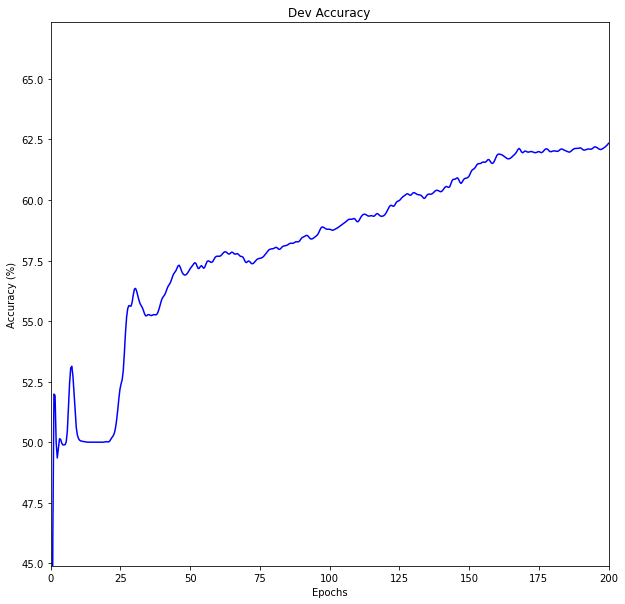

In [14]:
def plot(x, y, epochs):
    
    plt.figure(figsize=(10,10))
    
    x = np.array(x)
    y = np.array(y)
    
    xy = make_interp_spline(x, y)
    X_ = np.linspace(x.min(), x.max(), 500)
    Y_ = xy(X_)
    
    plt.plot(X_, Y_, color='blue')
    
    plt.title('Dev Accuracy')
    
    plt.xlabel('Epochs')
    
    plt.ylabel('Accuracy (%)')
    
    plt.xlim([0,epochs])
    
    y = np.delete(y,0)
    
    min_y = min(y)
    max_y = max(y)
    min_y -= 5
    max_y += 5
    
    if min_y < 0:
        min_y = 0
    if max_y > 100:
        max_y = 100
        
    plt.ylim([min_y, max_y])
    
    plt.show()
    
recurrent = Model(len(vocab), len(categories), is_lstm = best_ct, embedding_size = best_es, hidden_size = best_hs, init_dev = best_id)
recurrent.to('cpu')
optimiser = torch.optim.Adam(recurrent.parameters())

epochs = 200
x = [0]
y = [0]

for step in range(1, epochs+1):
    
    print("Epoch: ", step)
    optimiser.zero_grad()
    output = recurrent(indexed_train_x, tensor_train_len)
    error = torch.nn.functional.cross_entropy(output, tensor_ind_train_y)
    error.backward()
    optimiser.step()
    
    with torch.no_grad():
        targets = np.array(tensor_ind_dev_y, np.int64)
        probability = torch.relu(recurrent(indexed_dev_x, tensor_dev_len))
        output = probability.detach().numpy().argmax(axis=1)
        accuracy = (targets == output).sum()/len(targets)
        
    x.append(step)
    y.append(accuracy*100)
    print("Finished Epoch: ", step)
    print("---")
    
plot(x,y,epochs)

Measure the accuracy, precision, recall, and F1-score of this classifier on the test set.

In [19]:
targets = np.array(tensor_ind_test_y, np.int64)

with torch.no_grad():
    probability = torch.sigmoid(recurrent(indexed_test_x, tensor_test_len))
    output = probability.detach().numpy().argmax(axis=1)
    
tp = 0 
tn = 0
fp = 0
fn = 0

for i in range(len(targets)):
    if(targets[i] == output[i]):
        if(targets[i] == 0):
            tn += 1
        else:
            tp += 1
    else:
        if(targets[i] == 0):
            fp += 1
        else:
            fn += 1
            
accur = find_accuracy(tp, tn, len(targets))
precision = find_precision(tp, fp)
recall = find_recall(tp, fn)
f1_score = find_f1(precision, recall)


print('Accuracy: {:.2%}'.format(accur))
print('Precision: {:.2%}'.format(precision))
print('Recall: {:.2%}'.format(recall))
print('F1-Score: {:.2%}'.format(f1_score))



Accuracy: 61.84%
Precision: 62.05%
Recall: 61.01%
F1-Score: 61.52%


Output a confusion matrix of the trained model on the test set.

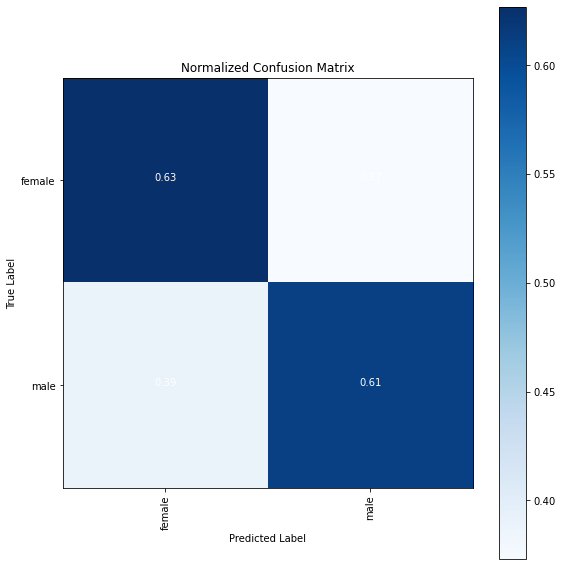

In [20]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
confusion = confusion_matrix(targets, output)

plt.figure(figsize=(8,8))
plt.grid(b=False)
plot_confusion_matrix(confusion, classes=categories, normalize=True, title='Normalized Confusion Matrix')
plt.show()

Output 5 examples of correctly classified text for each gender and 5 examples of incorrectly classified text for each gender (so 20 text examples in total), all of which must be from the test set.
This is assuming that you have at least 5 instances of each group.
If you have less, then show whatever is available.

In [21]:
male = []
female = []
false_male = []
false_female = []
tests = [female, male, false_female, false_male]
testlabels = ["Correct Female Sentences", "Correct Male Sentences", "Incorrect Female Sentences", "Incorrect Male Sentences"]

threshold = 5
counter = 0
total = 0

while counter < threshold * 4:
    total += 1
    
    if total == (len(test_x)):
        break
    
    ran = random.randint(0, len(test_x) - 1)
    if(output[ran] == targets[ran]):
        if(targets[ran] == 0):
            if(len(female) < threshold):
                counter += 1
                female.append(ran)
            else:
                continue
        else:
            if(len(male) < threshold):
                counter += 1
                male.append(ran)
            else:
                continue
    else:
        if(targets[ran] == 0):
            if(len(false_female) < threshold):
                counter += 1
                false_female.append(ran)
            else:
                continue
        else:
            if(len(false_male) < threshold):
                counter += 1
                false_male.append(ran)
            else:
                continue
            
for i, t in enumerate(tests):
    print(testlabels[i] + "  Classification : ")
    for j, x in enumerate(tests):
        print(str(j+1) + ")" + test_x[x])
    print()

Correct Female Sentences  Classification : 
2877    1)oh yeh, and today that dude took my parking ...
3758    1)'ohhh i have to put all the different fantas...
4539    1)r and kama are home. maybe we should have a ...
3946    1)i thought that abby wasn't going to scott's ...
3442    1)presents! will came home from work today wit...
Name: text, dtype: object
1815    2)you're born, and then you die. anything in t...
809     2)with other natural flavors there are donuts ...
2146    2)urllink always building something in japan.....
1494    2)it's odd and sad - mary magdalene is here bu...
2225    2)hi im jon, i had a blog on mindsay, but it g...
Name: text, dtype: object
3847    3)life is all about ass...either you are cover...
2436    3)well things r stupid life is boring yea that...
2486    3)urllink sometimes the spring/winter switch i...
2903    3)here it is, ladies and gentlemen! a coddled ...
3694    3)urllink stephen e. fabian: lur (from dweller...
Name: text, dtype: object
892     

Remember the list of important tokens determined previously (from the logistic regression classifier)?
Write code that takes all the texts in the test set that have at least one of the important tokens and shows the percentage of these texts that were correctly classified.
Similarly, take all the texts that don't have any of the important tokens and show the percentage of these texts that were correctly classified (so 2 percentages in total).

In [23]:
def deep_percentage(text, data, output, target):
    
    important = 0
    total_important = 0
    other = 0
    total_other = 0
    
    for i,j in enumerate(data["text"]):
        j = j.lower()
        
        if re.compile('|'.join(text), re.IGNORECASE).search(j):
            
            total_important += 1
            
            if output[i] == target[i]:
                
                important += 1
                
        else:
            
            total_other += 1
            
            if output[i] == target[i]:
                
                other += 1
        
    important_tokens = important/total_important
    other_tokens = other/total_other
    
    return (important_tokens, other_tokens)

important_tokens, other_tokens = deep_percentage(ten, test, output, targets)

print("Accuracy of Important Tokens: {:.2%}".format(important_tokens))
print("Accuracy of Other Tokens: {:.2%}".format(other_tokens))


Accuracy of Important Tokens: 64.69%
Accuracy of Other Tokens: 61.62%


## Conclusion (10%)

Write, in less than 300 words, your interpretation of the results and how you think the model could perform better.
You should talk about things like overfitting/underfitting and whether the model is learning anything deep about how the different genders write or if it's just basing everything on the words used.

Both accuracies being 61.84% and a 62.38% from the Recurrent Neural Network and the Linear Regression Model can be understood to an extent given the nature of the datasets. Considering the indifference in language between the two genders such an accuracy can be interpreted as a not bad accuracy. 

### The Linear Regression Approach 
With a 62.38% accuracy the linear regression model showed signs of overfitting as the number of epochs was getting higher. From the results above it can be seen that after 200 epochs, the model starts overfitting and accuracy starts to decline slowly.

### Recurrent Neural Network 
First and foremost, a recurrent neural network was used over a convolutional neural network due to the 'fact' that RNNs usually perform better when handling text rather than CNNs. Although despite having a slighly less accurate model than that of the linear regression model,
the RNN still comes out with slightly over 61% accuracy. From the graph plotted, it can be noticed that after roughly 10 epochs the model takes a dip in accuracy, but after that it increases quite rapidly to the high 50s and 60%s in accuracy. This is due to the use of the RELU activation function.
Moreover, regarding the confusion matrix plotted it can be observed that the model slightly gives an edge to classification for the female gender rather than that of the male. 